In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import HTML,display
warnings.filterwarnings('ignore')
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [66]:
#Импортируем таблицу в df и проведем прреобразование данных#
url = 'https://docs.google.com/spreadsheets/d/1YZ7ZTjBIH875ynQGpC9JsF69XfbtITI-v-KtrDTwRZo/edit?usp=sharing'
df = pd.read_csv(url.replace('edit?usp=sharing', 'export?format=csv'),header=1)
df = df.iloc[:,:4]
df.date = pd.to_datetime(df.date)
df.pay_sum = df.pay_sum.str.replace(r'\s+','',regex=True).astype(int)
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month

In [67]:
#df.isna().sum()

In [53]:
#df.head()

**Поскольку 2021 год еще продолжается, будем сравнивать показатели выручки за период 2021 к соответсвущему периоду за 2020 год, по имеющимся данным это январь-август**

In [56]:
#max(df.month[df.year==2020]), max(df.month[df.year==2021])

In [57]:
df_pp = df[df.month < 9]

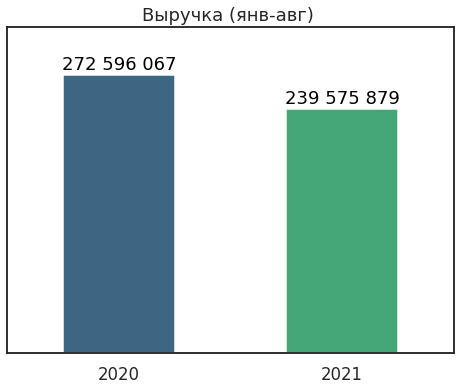

In [80]:

sns.set_theme(style="white", context="talk")
plt.rcParams["figure.figsize"] = (8, 6)
data = df_pp.groupby(by=df_pp.year).sum().reset_index()
barplot = sns.barplot(x = 'year',
            y = 'pay_sum',
            data = data,
            palette="viridis",
            dodge=False)
for index, row in data.iterrows():
    barplot.text(row.name,row.pay_sum*1.02, '{0:,}'.format(row.pay_sum).replace(',', ' ') , color='black', ha="center")
for patch in plt.gca().patches :
        current_width = patch.get_width()
        diff = current_width - 0.5
        patch.set_width(0.5)
        patch.set_x(patch.get_x() + diff * .5)
plt.title("Выручка (янв-авг) ")
plt.gca().set_ylim([0,320000000])
plt.xlabel(None)
plt.ylabel(None)
plt.gca().set_yticklabels([]);

**Падение выручки за период янв-авг 2021 составляет 33 020 188 у.е или 12.11% от прошлого года**

In [59]:
diff = df_pp.groupby(by=df_pp.year).sum().apply(lambda x : x[2020] -x[2021]).values[0]
diff_perc = df_pp.groupby(by=df_pp.year).sum().apply(lambda x : (x[2020] -x[2021])/x[2020]*100).values[0]
# diff, round(diff_perc,2)

**Рассмотрим различие в продажах в разрезе имеющихся категорий**

**Регионы**

По региону RU и UA падение на -26 047 757 и  -9 313 180 , что в сумме составило - 35 360 937 у.е ,которое не покрывает рост в регионах EU и USA на 1 364 636 и 976 113

In [83]:
diff_byregion = df_pp.groupby(by=[df_pp.year,df_pp.country]).sum()['pay_sum'].unstack()
diff_byregion = diff_byregion.append(diff_byregion.apply(lambda x: x.iloc[1] - x.iloc[0]).to_frame().T)
diff_byregion.rename(index={0:"Difference"},inplace=True)
diff_byregion.style.set_table_attributes('style="font-size: 18px"')

country,EU,RU,UA,USA
2020,41193542,126471740,76974723,27956062
2021,42558178,100423983,67661543,28932175
Difference,1364636,-26047757,-9313180,976113


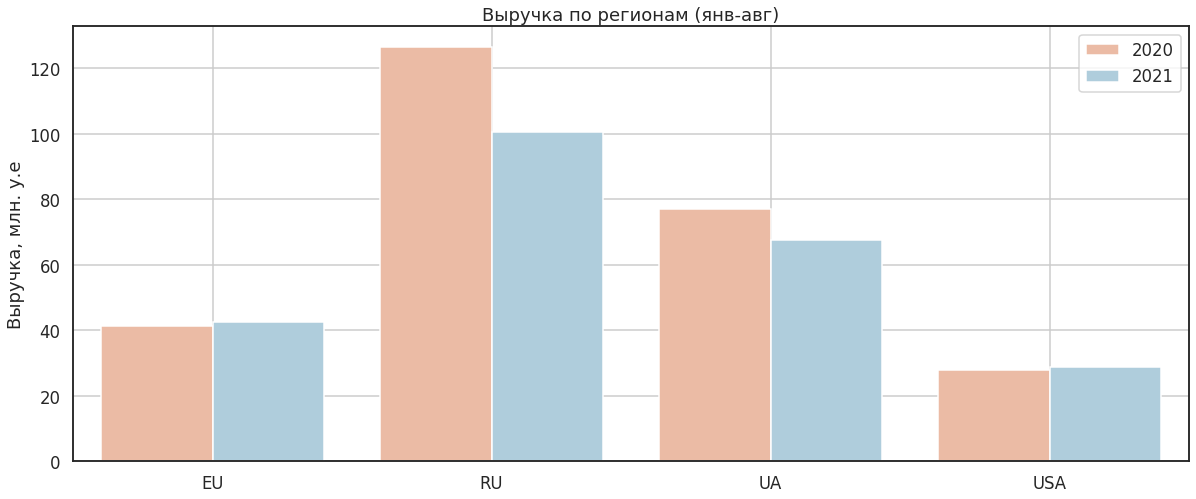

In [61]:
data = df_pp.groupby(by=[df_pp.year,df_pp.country]).sum().reset_index()
data['pay_sum'] = data['pay_sum']/1000000
plt.rcParams["figure.figsize"] = (20, 8)
barplot = sns.barplot(x = 'country',
                      hue ='year',
                      y='pay_sum',
                      data = data,
                      palette='RdBu'
                      )

plt.title("Выручка по регионам (янв-авг)")
plt.xlabel(None)
plt.grid()
plt.legend()
plt.ylabel("Выручка, млн. у.е");

**Тип продукта**

После добавления категории "тип продукта" заметим,что на общее падение выручки повлияло падение продаж продукта **pack**  в регионе *RU* на 27 222 519 у.е. и падение продаж продукта **subscription**  в регионе *UА* на 10 748 020 у.е.


In [84]:
diff_bytype = df_pp.pivot_table(index=['country','type'],columns='year',values='pay_sum',aggfunc='sum')
diff_bytype.join(diff_bytype.apply(lambda x: x[2021] - x[2020],axis=1).to_frame()).rename(columns={0:"diff"}).style.set_table_attributes('style="font-size: 18px"')

**Рассмотрим диамику продажах по региону и продукту с отрицательным приростом **

Снижение выручки в регионе **RU** по продукту **pack** началось с янв-2021 по май-2021

Снижение выручки в регионе **UA**  по продукту **subscription** началось с фев-2021 по апр-2021 

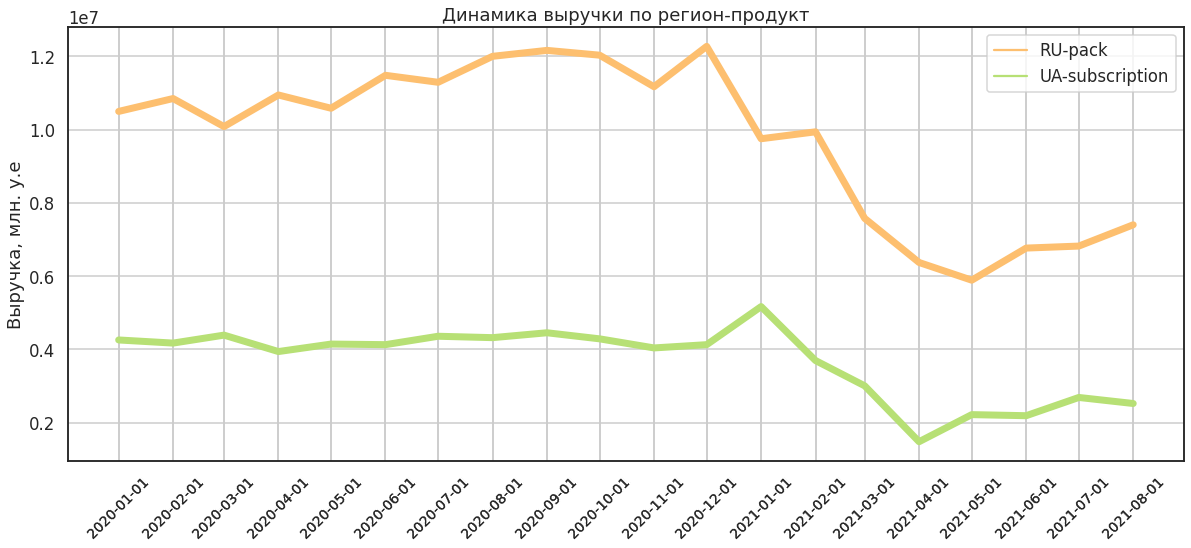

In [46]:
data = df[((df['country']=='RU') & (df['type']=='pack')) | ((df['country']=='UA') & (df['type']=='subscription'))]
data['country-type'] = data['country'] + "-" + data['type']
sns.lineplot(data=data,
             x='date',
             y='pay_sum',
             hue='country-type',
             palette = "RdYlGn",
             linewidth=7
             )
plt.rcParams["figure.figsize"] = (20, 8)
plt.grid()
plt.gca().set_xticks(data.date)
plt.xticks(rotation=45,size=14)
plt.xlabel(None)
plt.ylabel("Выручка, млн. у.е")
plt.title("Динамика выручки по регион-продукт")
plt.legend();

**Вывод:**

По продукту **pack** в регионе **RU** с *янв-2021* по *май-2021* происходило падение продаж, 
такая же динамика по продукту **subscription** в регионе **UA** c *фев-2021* по *апр-2021*, что привело к  снижению 
выручке по продукту **pack** в регионе **RU** и продукту **subscription** в регионе **UA** на *27 222 519 у.е.* и *10 748 020 у.е.*, поскольку рост продаж альтернативных продуктов в данных регионах не компенсировал падение общая разница  по регионам **RU** и  **UA** составила *-26 047 757 у.е.* и *-9 313 180 у.е.* 

По регионам **EU** и **USA** прирост не компенсировал данное падение, в итоге за период *янв-авг 2021 года* по сравнению с *2020 годом* разница по выручке составляет *-33 020 188 у.е* или *-12.11%* 

In [81]:
CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))